<a href="https://colab.research.google.com/github/xiao-yucheng0625/ML-100-DAY/blob/main/Sentiment140_dataset_with_1_6_million_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. About dataset

Context

This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

Content

It contains the following 6 fields:

1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2. ids: The id of the tweet ( 2087)

3. date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.

5. user: the user that tweeted (robotickilldozr)

6. text: the text of the tweet (Lyx is cool)

# 2. Importing Libraries

* Pandas 是 Python 的一個數據處理函式庫，主要用於處理結構化數據（如表格或時間序列數據）。
* NumPy 是 Python 的數值計算函式庫，特別擅長處理數值陣列與矩陣運算。
* Matplotlib 是 Python 最基本的數據視覺化函式庫，主要用來畫圖表。
* Seaborn 是基於 Matplotlib 的高階統計數據視覺化函式庫，提供更美觀的圖表樣式。
* SciPy 是用於科學計算的函式庫，stats 子模組提供了各種統計分析工具，如常態分佈、t 檢定、線性回歸等。
* IPython.display 提供 display() 函式，能在 Jupyter Notebook 或 IPython 環境中更友善地顯示 Pandas DataFrame、圖片或 HTML 內容。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

# 3. Understanding the Data

## 3.1 Reading the dataset with Pandas

1. 如果沒指定編碼，Pandas 可能會用 UTF-8，但如果遇到無法解碼的字元，可能會報錯，所以 latin1 可以避免這類錯誤。
2. header=None 表示 讀取 CSV 時不將第一行視為標題（column names），而是將所有數據當成普通數據。

In [2]:
data = pd.read_csv(r"/content/training.1600000.processed.noemoticon.csv", encoding="latin1", header=None)

The dataset consists of 1,600,000 rows and 6 columns.

In [3]:
data.shape

(1600000, 6)

In [4]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 3.2 Rename the columns

可以發現，行被數字0~5所命名，因此必須要重新命名各行（colunms）的名稱。

In [5]:
columns = ["sentiment", "ids", "date", "flag", "user", "tweet"]
data.columns= columns

在 Pandas DataFrame 中，data.info() 用來 顯示 DataFrame 的結構資訊，包括：

* 總行數與列數
* 每個欄位的名稱、非空值數量、資料型態
* 記憶體使用量

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# 4. Data Preprocessing and Cleaning

## 4.1 找到與輸出最有關的輸入特徵

首先，專注於其中一個輸入特徵 tweet，它與輸出目標 sentiment 有很大的關係，其餘皆不太影響。

In [7]:
df = data[["tweet", "sentiment"]].copy()

提高數據集品質，我們需要透過移除不必要的元素（例如連結、特殊字元和停用詞）。

* re：Python 的正則表達式（Regular Expressions）模組，用來處理字串替換、移除網址等操作。
* nltk：自然語言處理工具包（Natural Language Toolkit），提供許多 NLP 相關函式，例如停用詞（stopwords）和詞幹提取（stemming）。
* nltk.corpus.stopwords：用來加載英文的停用詞（例如：the, is, in, and）。
* nltk.stem.PorterStemmer：用來進行詞幹提取（Stemming），將單詞還原為詞根（例如 running → run）。
* wordcloud.STOPWORDS：來自 wordcloud 函式庫，內建一些額外的停用詞，可以搭配使用。

## 4.2 資料清洗

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import STOPWORDS

In [9]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(["amp", "rt", "lt", "gt"]) # 更新沒有語意的詞
# "amp"：代表 &（HTML 轉義符號 &amp;）。
# "rt"：代表 "Retweet"（轉推）。
# "lt" 和 "gt"：代表 < 和 >（HTML 符號）。

stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https?://\S+", "", tweet) # 移除連結 # https? 表示 http 或 https
    tweet = re.sub(r"@\w+|#", "", tweet) # 移除 @ 或 #
    tweet = re.sub(r"[^\w\s]|[\d]", "", tweet) # 標點符號或數字
    tweet = " ".join([stemmer.stem(word) for word in tweet.split() if word not in stop_words])
    return tweet

In [11]:
df["clean_tweet"] = df["tweet"].apply(clean_tweet)
df.head()

,tweet,sentiment,clean_tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww that bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,0,upset cant updat facebook text might cri resul...
2,@Kenichan I dived many times for the ball. Man...,0,dive mani time ball manag save rest go bound
3,my whole body feels itchy and like its on fire,0,whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",0,behav im mad cant see


# 5. Explorary Data Analysis(EDA)

## 5.1 改變 label 的表示方式，增加可讀性

In [12]:
df["sentiment"] = df["sentiment"].replace({0: "Negative", 4: "Positive"})
df.head()

,tweet,sentiment,clean_tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative,awww that bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,Negative,upset cant updat facebook text might cri resul...
2,@Kenichan I dived many times for the ball. Man...,Negative,dive mani time ball manag save rest go bound
3,my whole body feels itchy and like its on fire,Negative,whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",Negative,behav im mad cant see


## 5.2 查看 Sentiment 的分布狀況

透過視覺化，計算每個 sentiment （正/負面）數量，判斷資料集是否 balanced 或 biased。

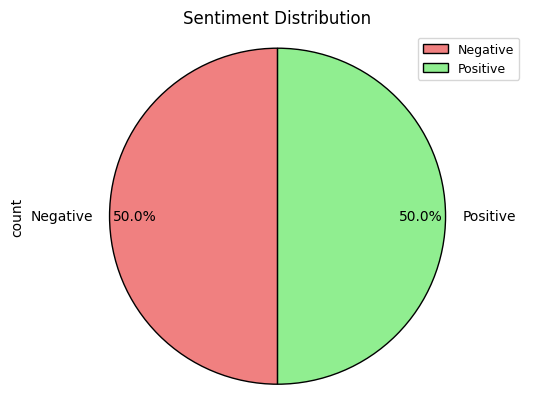

In [13]:
import matplotlib.pyplot as plt

df["sentiment"].value_counts().plot(kind="pie",
                autopct='%1.1f%%', # 顯示到小數點一位
                pctdistance=0.85, # 百分比文字距離圓心的距離
                startangle=90, # 從圓正上方開始畫圖
                colors=["lightcoral", "lightgreen"],
                wedgeprops={'edgecolor': 'black'})

plt.title('Sentiment Distribution')
plt.axis('equal')  # 保持圓形
plt.legend(labels=df["sentiment"].value_counts().index,
           loc='upper right', fontsize=9)

plt.show()

## 5.3 判斷在各類別（正/負面）中最常出現的字

透過使用 WordCloud 的視覺化方式，找出 tweet 中常出現在類別為正面或負面的字詞。

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [15]:
# 篩選出情緒為 Positive/Nagative 的推文，並用空格連接在一起
positive_words = " ".join(df[df["sentiment"] == "Positive"]["clean_tweet"])
negative_words = " ".join(df[df["sentiment"] == "Negative"]["clean_tweet"])

產生在正面類別中常出現的字詞文字雲

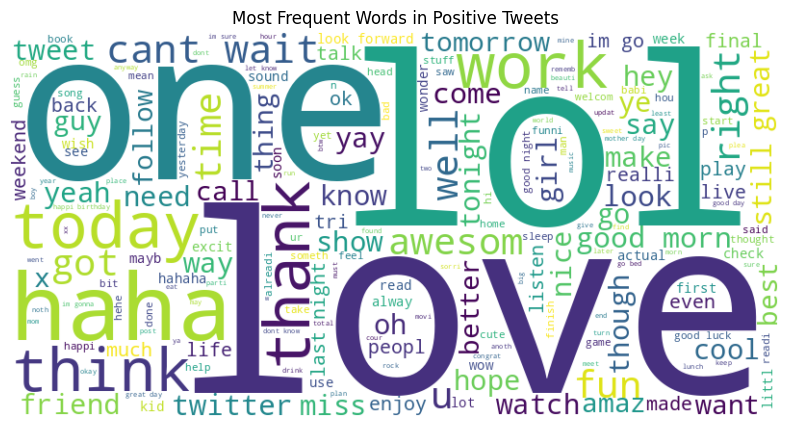

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(positive_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear") # 讓圖像顯示更平滑
plt.axis("off")
plt.title("Most Frequent Words in Positive Tweets")
plt.show()

一樣的方式，產生在負面類別中常出現的字詞文字雲

In [17]:
"""
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_words)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Negative Tweets")
plt.show()
"""

'\nwordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_words)\nplt.figure(figsize=(10,5))\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.title("Most Frequent Words in Negative Tweets")\nplt.show()\n'

特別注意，你會發現在正/負面類別中，常出現的字詞有一些是重複的，但是它們出現的頻率或次數是不一樣的。

## 5.4 分析 tweet 長度對於情緒的影響

增加新的 x 特徵，觀察 tweet 的長度。

用 lambda 匿名函式對這個欄位中的每一列文字執行一段操作

In [18]:
df["tweet_length"] = df["clean_tweet"].apply(lambda x: len(x.split()))
df.head()

,tweet,sentiment,clean_tweet,tweet_length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Negative,awww that bummer shoulda got david carr third day,9
1,is upset that he can't update his Facebook by ...,Negative,upset cant updat facebook text might cri resul...,12
2,@Kenichan I dived many times for the ball. Man...,Negative,dive mani time ball manag save rest go bound,9
3,my whole body feels itchy and like its on fire,Negative,whole bodi feel itchi like fire,6
4,"@nationwideclass no, it's not behaving at all....",Negative,behav im mad cant see,5


經過資料（文字）清洗後，觀察是否有 tweet 長度為零的狀況。

同時也能查看原始資料集，這些經過清洗後長度為零的 tweet，在原始資料裡大多只包含 user mentions 而已。

In [19]:
zero_len = df[df["tweet_length"]==0][["tweet" ,"clean_tweet","tweet_length"]]
display(zero_len.shape)

(7090, 3)

移除掉經過清洗後那些 tweet_length=0 以及重複的資料。

In [20]:
df = df[df["tweet_length"] != 0].reset_index(drop = True) # 把舊的索引丟掉
df = df.drop_duplicates(subset=['clean_tweet'], keep='first') # 刪除重複 # 保留第一筆重複
display(df.shape)

(1475147, 4)

計算 tweet 平均長度

In [21]:
tweet_avglen = df.groupby(["sentiment"]).agg(
   mean = ("tweet_length", "mean")
)

tweet_avglen = tweet_avglen.transpose()
tweet_avglen

sentiment,Negative,Positive
mean,7.694833,7.345752


利用 histogram 建構正面/負面類別中的文字長度分布。

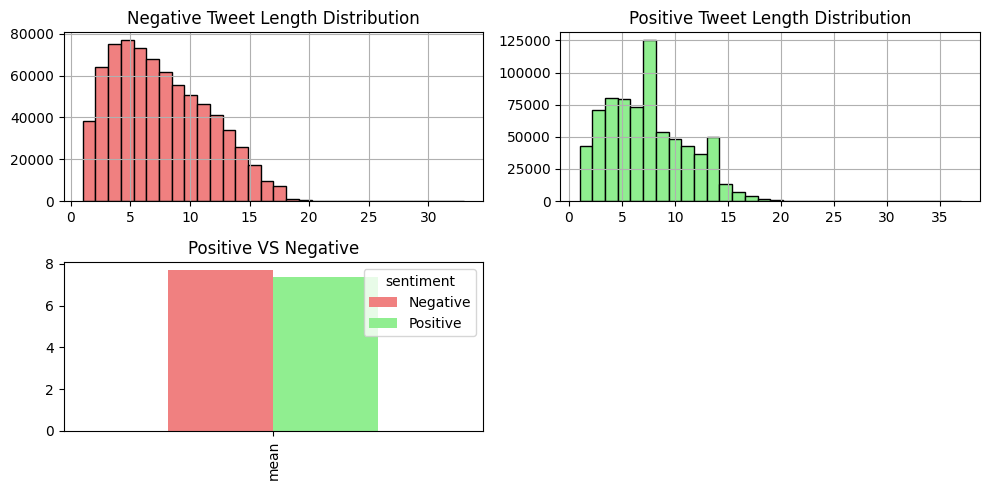

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5)) # 建立4個區塊


df[df["sentiment"]=="Negative"]["tweet_length"].hist(color="lightcoral", edgecolor="black", ax=axes[0, 0], bins=30)
df[df["sentiment"]=="Positive"]["tweet_length"].hist(color="lightgreen", edgecolor="black", ax=axes[0, 1], bins=30)
tweet_avglen.plot(kind="bar", color = ("lightcoral", "lightgreen"), ax = axes[1, 0] )

axes[0, 0].set_title("Negative Tweet Length Distribution")
axes[0, 1].set_title("Positive Tweet Length Distribution")
axes[1, 0].set_title("Positive VS Negative")
fig.delaxes(axes[1,1]) # 移除右下角的區塊

plt.tight_layout() # 自動調整間距
plt.show()

# 6. Data modeling

In [27]:
!pip install --upgrade numpy
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 33.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found e

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

## 6.1 Bag-of-Words (BoW)
在應用 Bag-of-Words (BoW) 技術 後，從數據集中提取出了 373,727 個唯一詞彙（features），代表我們的詞彙表大小（vocabulary size）。

BoW
* 建立詞彙表(Volcabulary creation)
* 向量化(Vectorization)
* 不考慮語法或單詞順序

In [ ]:
cv = CountVectorizer() # 建立 BoW 模型
X = cv.fit_transform(df["clean_tweet"])
bow_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names_out())
print(bow_df)

vocab_size = len(cv.vocabulary_) # 計算詞彙表大小
print(f"Bag-of-Words 技術提取的詞彙表大小: {vocab_size}")

In [ ]:
cv = CountVectorizer(max_features=100000)
X = cv.fit_transform(df["clean_tweet"])
len(cv.get_feature_names_out())

改變目標變數 y 為 0(負面) 與 1(正面)

In [ ]:
y = df["sentiment"].map({"Negative": 0, "Positive": 1})

## 6.2 將資料拆分成訓練集與測試集

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state =0)

對輸入 x 做標準化處理

In [ ]:
scaler = StandardScaler(with_mean=False) # 資料通常是稀疏的，因此不適合減去均值
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## 6.3 打造 LogisticRegression 模型

In [ ]:
model = LogisticRegression(max_iter=500, solver='saga') # solver 代表用來優化損失函數的演算法
model.fit(x_train_scaled, y_train)

In [ ]:
y_pred = model.predict(x_test_scaled)
y_pred

## 6.4 （分類）模型評估

計算模型預測正確的比例（Accuracy）

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.4f}%')

建立混淆矩陣，分別有 TP、FP、FN、TN 四類

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

顯示分類的詳細指標，分別有 Precision、Recall、F1-score、Support

In [ ]:
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

視覺化混淆矩陣，可以使用 seaborn

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Visualization")
plt.show()

# 7. 觀察訓練好的模型預測成果

In [ ]:
sent = pd.DataFrame({"tweet": ["I am very happy today", "lol, i have depression"]})
sent["clean_tweet"] = sent["tweet"].apply(clean_tweet)
sent

In [ ]:
pre = cv.transform(sent["clean_tweet"])
pre = scaler.transform(pre)
predict_sent = model.predict(pre)
predict_sent